# Deriving Potentials for Coarse-Grained Nanoparticles

Here, we move beyond the simple point-particle system.  Our system will now contain two coarse-grained nanoparticles, constructed as a spherical shell of coarse-grained beads, or child particles.  To define our forcefield, we need to derive the interaction between two of these coarse-grained beads.  This is achieved by matching the interaction potential between two coarse-grained nanoparticles to the potential between two all-atom nanoparticles.

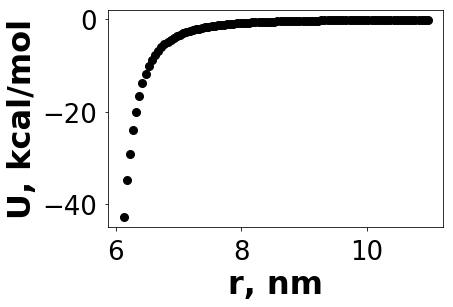

In [1]:
import pkg_resources

import numpy as np

import nanoparticle_optimization
from nanoparticle_optimization.target import load

resource_package = nanoparticle_optimization.__name__
resource_path = '/'.join(('utils', '3nm_target.txt'))
target = load(pkg_resources.resource_filename(resource_package, resource_path))

target.separations /= 10.0

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(target.separations, target.potential, linestyle='None', marker='o', color='black')
plt.xlabel('r, nm')
plt.ylabel('U, kcal/mol')

We load atomistic target data for the interaction potential between two nanoparticles with radii of 3nm.

In [2]:
from nanoparticle_optimization.lib.CG_nano import CG_nano

nano = CG_nano(r=3.0, sigma=0.8)
nano.visualize()

/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_core/application.py:106: DeprecationWarning: metadata {'config': True} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  help="""Generate default config file."""
/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/notebook/nbextensions.py:628: DeprecationWarning: metadata {'config': True} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  user = Bool(False, config=True, help="Whether to do a user install")
/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/ipywidgets/widgets/widget.py:166: DeprecationWarning: Widget._keys_default is deprecated in traitlets 4.1: use @default decorator instead.
  def _keys_default(self):


The coarse-grained nanoparticle is constructed as a hollow sphere of pseudo-atoms.  We have created a nanoparticle with a radius of 3nm (to match our atomistic model) and a `sigma` of 0.8nm.  `Sigma` defines the radius of the pseudo-atoms and also corresponds to the `sigma` in the Mie forcefield defining their interactions.  Thus, larger values of `sigma` can be used to create a more coarse-grained nanoparticle.

In [3]:
from nanoparticle_optimization.forcefield import Mie, Parameter
from nanoparticle_optimization.system import System

sigma = Parameter(value=0.8, fixed=True)
epsilon = Parameter(value=6.0, upper=20.0, lower=0.1)
n = Parameter(value=14.0, upper=40.0, lower=10.0)
m = Parameter(value=5.0, upper=20.0, lower=3.0)
ff = Mie(sigma=sigma, epsilon=epsilon, n=n, m=m)

system = System(nano)

We hold `sigma` fixed to the radius of the psuedo-atoms and allow `epsilon`, `n`, and `m` to be optimized.

In [4]:
from nanoparticle_optimization.optimization import Optimization

optimization = Optimization(ff, system, target, configurations=25, verbose=True)
optimization.driver()

/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/openmdao/units/units.py:729: DeprecationWarning: This method will be removed in future versions.  Use 'parser.read_file()' instead.
  _UNIT_LIB.readfp(libfilepointer)


##############################################
Setup: Checking root problem for potential issues...

No recorders have been specified, so no data will be saved.

Setup: Check of root problem complete.
##############################################

Current values:
n:	14.0
m:	5.0
epsilon:	6.0
Residual:	0.6457724751592058

Current values:
n:	14.0
m:	5.0
epsilon:	6.0
Residual:	0.6457742147399187

Current values:
n:	21.0
m:	5.0
epsilon:	6.0
Residual:	0.5527630650625182

Current values:
n:	21.0
m:	7.5
epsilon:	6.0
Residual:	0.48241312852490353

Current values:
n:	21.0
m:	7.5
epsilon:	9.0
Residual:	0.31276071801802674

Current values:
n:	24.162581117216227
m:	8.354303802988344
epsilon:	11.472235910058078
Residual:	0.4850431545736316

Current values:
n:	17.602006164349145
m:	7.614753339400739
epsilon:	9.33208013996101
Residual:	0.2519682089021506

Current values:
n:	16.880995147006946
m:	6.425048396999162
epsilon:	9.6731712978533
Residual:	0.20893033452378335

Current values:
n:	15.2691094290

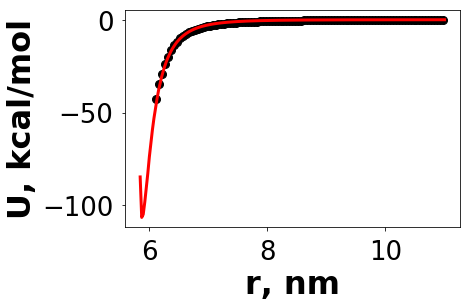

In [5]:
matched_potential = [potential[0] for potential in system.calc_potential(optimization.forcefield, 
                                                            np.linspace(5.85,11,200),
                                                            configurations=25)]

plt.plot(target.separations, target.potential, linestyle='None', marker='o', color='black')
plt.plot(np.linspace(5.85,11,200), matched_potential, marker='None', color='red')
plt.xlabel('r, nm')
plt.ylabel('U, kcal/mol')

The optimized potential between the pseudo-atoms leads to a nanoparticle-nanoparticle interaction potential that closely matches the all-atom target data, with a fit of around 95%.